## 1. Importando módulos e funções
    Por: Rodolpho C. Braga (RCB)                  02 de Novembro de 2018.
         
    

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner
#Modeling tools
exec(open('tools/modeling.py').read())
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Descriptors import MolLogP
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import Descriptors
import sys
import multiprocessing
from standardiser import break_bonds, neutralise, rules, unsalt
from standardiser.utils import StandardiseException, sanity_check
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from sklearn.externals import joblib


import sys
def warn(*args, **kwargs):
    pass  # to suppress sklearn warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn
#Modeling tools
exec(open('tools/modeling.py').read())
from rdkit.Chem.Descriptors import MolLogP
from rdkit.Chem import Descriptors
from tools import tools
from tools import  pipeline as p
from tools import  sar
from sklearn.metrics import cohen_kappa_score
import csv
from rdkit.Chem import MACCSkeys
from sklearn.model_selection import ShuffleSplit
import _pickle as cPickle
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
import bz2
from glob import glob
import _pickle as cPickle
import pickle
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


  * could not import Bokeh, plotting with Highcharts instead.
- no local installation of highcharts found, using web version.
- loading highcharts...


* SA scorer not available. RDKit's Contrib dir needs to be in the Python import path...
tools.tools                                   (190829-08:16)
- no local installation of JSME found, using web version.
* SA scorer not available. RDKit's Contrib dir needs to be in the Python import path...
> interactive IPython session.
tools.sar                                     (190829-08:16)


## 2. Entrada dos dados

Escolher a formda da entrada dos dados:
1. SDF
1. CSV

### 2.1 SDF

In [3]:
#Caminho do SDF
file= "data/skin_sens.sdf"

sdfInfo = dict(smilesName='SMILES',molColName='ROMol')
moldf = PandasTools.LoadSDF(file,**sdfInfo)
#Rename ROMol
moldf = moldf.rename(columns={'ROMol': 'Mol'})
#duplicatas by smiles
moldf = moldf.drop_duplicates(subset=['SMILES'])
#logP
moldf['logP'] = moldf['Mol'].apply(MolLogP)
#Remove moléculas sem esrtutura no RDKit
moldf = moldf[pd.notnull(moldf['Mol'])]
#Colunas no pandas
moldf.keys()

RDKit ERROR: [13:00:32] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bad dir
RDKit ERROR: Violation occurred on line 1755 in file /opt/conda/conda-bld/rdkit_1561471048963/work/Code/GraphMol/Chirality.cpp
RDKit ERROR: Failed Expression: dir == Bond::ENDUPRIGHT || dir == Bond::ENDDOWNRIGHT
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [13:00:32] Unexpected error hit on line 76259
RDKit WARNING: [13:00:32] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:00:32] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:00:32] WARNING: not removing hydrogen atom without neighbors


Index(['Compound name', 'SMILES', 'CASRN', 'LLNA result', 'LLNA class',
       'LLNA reference', 'ID', 'Mol', 'logP'],
      dtype='object')

### 2.2 CSV compactado para GZ

Os dados devem estar compactados para GZ (Reduz 90% do tamanho do arquivo).<br>
Você vai precisar:
1. Windows usar o 7-ZIP para compactar
1. Linux: gzip nomedoarquivo.csv
1. Em geral o encoding utf-8 funciona na maioria dos casos. Se nã uncionar usar o utf-16.

### 3. Definir a coluna a ser usada como variável dependente

In [4]:
moldf = moldf.rename(columns={'LLNA result': 'Outcome'})

,Compound name,SMILES,CASRN,Outcome,LLNA class,LLNA reference,ID,Mol,logP
0,"1,2-Benzisothiazolin-3-one",O=c1[nH]sc2ccccc12,2634-33-5,1,Moderate,ICCVAM (2013),,,1.5896

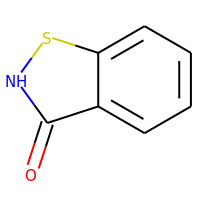

In [5]:
moldf.head(1)

,Compound name,SMILES,CASRN,Outcome,LLNA class,LLNA reference,ID,Mol,logP,RowID
999,?-Terpinene,C=C1CC=C(C(C)C)CC1,99-84-3,0,Non-sensitizer,ICCVAM (2013),,,3.30890,999
680,2-(4-methyl-2-nitrophenyl)diazenyl-3-oxo-N-phenylbutanamide,CC(=O)C(=NNc1ccc(C)cc1[N+](=O)[O-])C(=O)Nc1ccccc1,2512-29-0,0,,REACH (2008-2014),,,2.89882,680
681,"2-(4-nitrophenyl)diazenyl-3-oxo-N-(2-oxo-1,3-dihydrobenzimidazol-5-yl)butanamide",CC(=O)C(=NNc1ccc([N+](=O)[O-])cc1)C(=O)Nc1ccc2[nH]c(=O)[nH]c2c1,52846-56-7,0,,REACH (2008-2014),,,1.76000,681
682,"2-(benzyl)tert-butyl)amino)-1-(?,4-dihydroxy-m-tolyl)ethane",CC(C)(C)N(Cc1ccccc1)CC(O)c1ccc(O)c(CO)c1,24085-03-8,0,Non-sensitizer,ICCVAM (2013),,,3.21860,682
683,"2-(chloromethyl)oxirane; 2,6-dibromo-4-[2-(3,5-dibromo-4-hydroxyphenyl)propan-2-yl]phenol",CC(C)(c1cc(Br)c(O)c(Br)c1)c1cc(Br)c(O)c(Br)c1,40039-93-8,0,,REACH (2008-2014),,,6.47370,683
684,2-(phenoxy)ethoxybenzene,c1ccc(OCCOc2ccccc2)cc1,104-66-5,0,,REACH (2008-2014),,,3.14440,684
685,2-(phenoxy)ethyl 2-methylpropanoate,CC(C)C(=O)OCCOc1ccccc1,103-60-6,0,,REACH (2008-2014),,,2.26460,685
686,2-Amino-3-methylbutanoic acid,CC(C)C(N)C(=O)O,72-18-4,0,,REACH (2008-2014),,,0.05430,686
687,2-Aminoacetic acid,NCC(=O)O,56-40-6,0,,REACH (2008-2014),,,-0.97030,687
688,2-Aminoethyl-methylsulfone,CS(=O)(=O)CCN,49773-20-8,0,Non-sensitizer,ICCVAM (2013),,,-1.01030,688

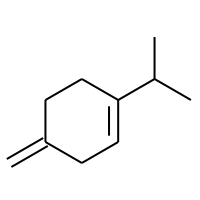
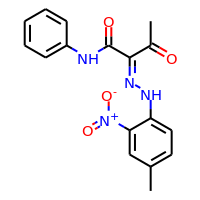
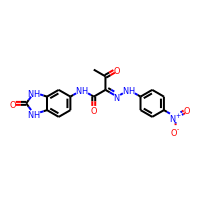
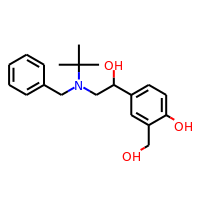
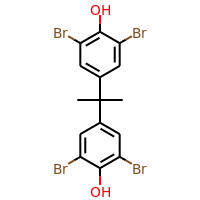
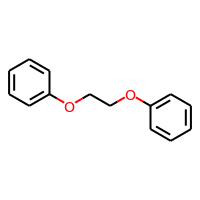
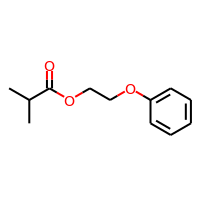
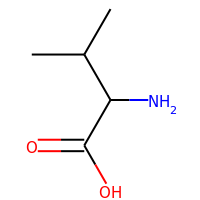
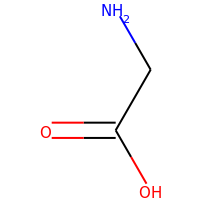
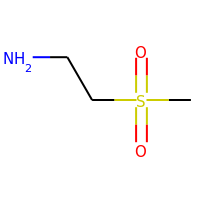
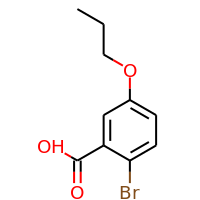
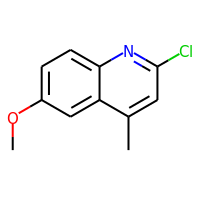
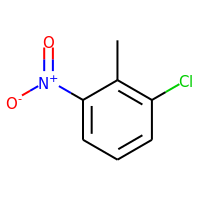
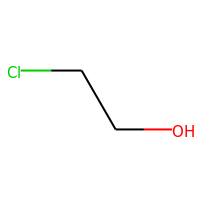
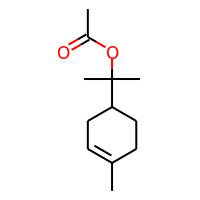
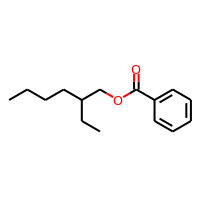
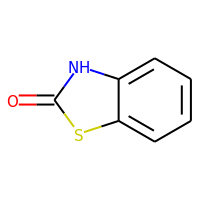
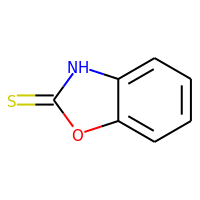
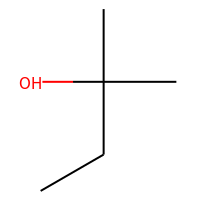
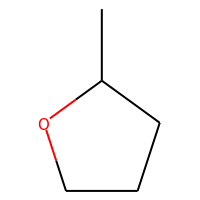
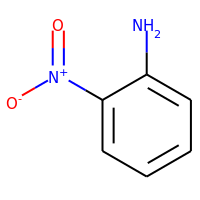
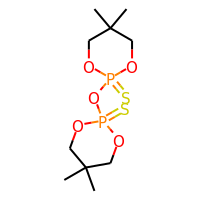
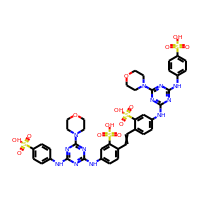
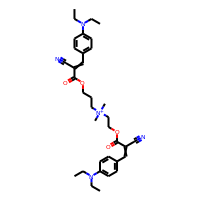
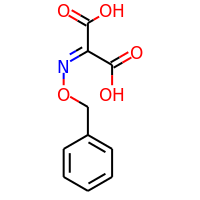
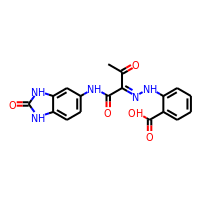
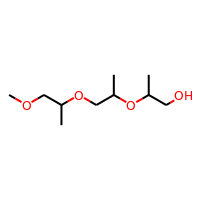
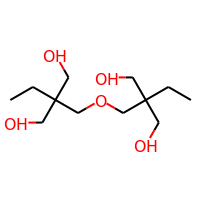
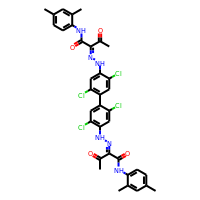
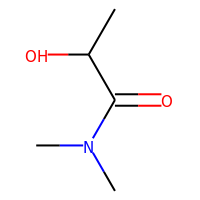
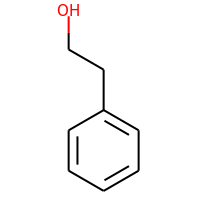
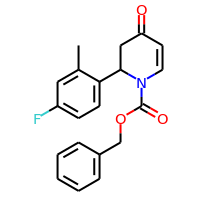
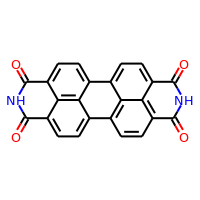
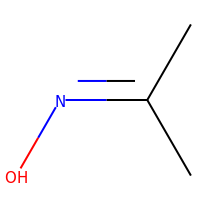
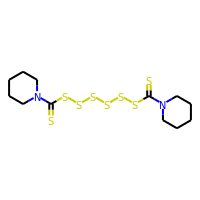
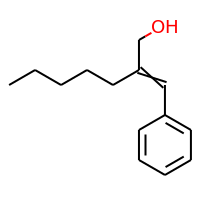
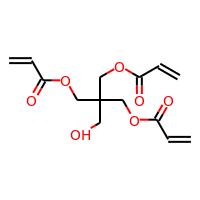
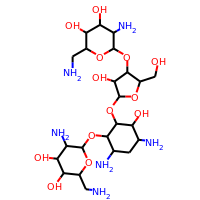
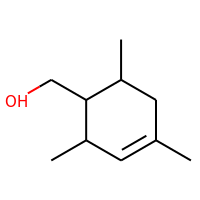
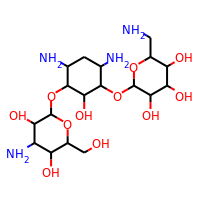
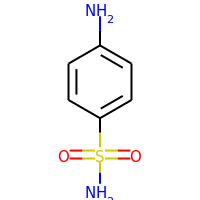
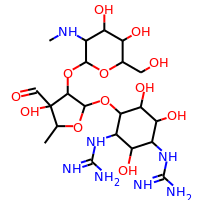
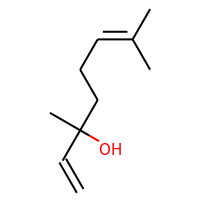
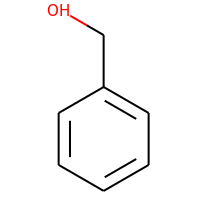
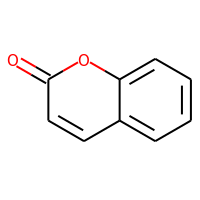
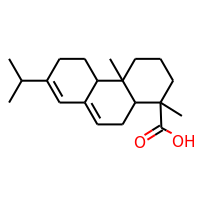
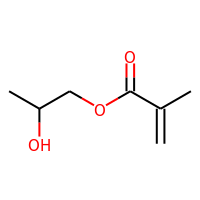
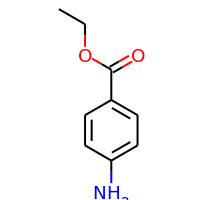
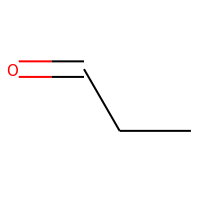
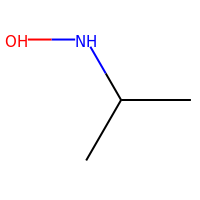
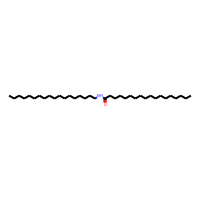
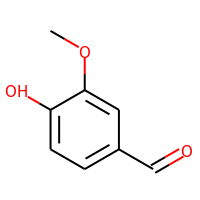
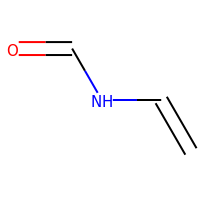
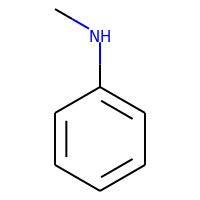
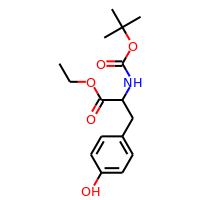
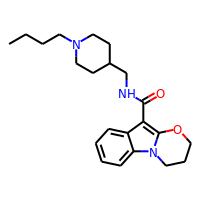
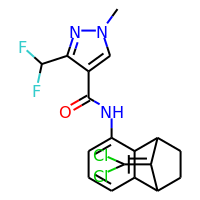
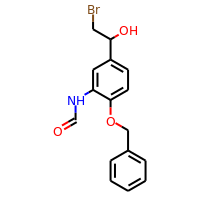
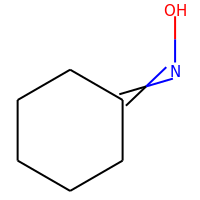
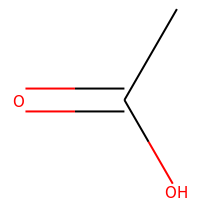

In [6]:
moldf= moldf.sort_values(['Outcome'], ascending=True)
moldf['RowID'] = moldf.index
moldf.head(300)

## 4. Definir a coluna a ser usada como variável dependente

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()


outcomes=(np.unique(moldf['Outcome']))
le.fit(list(set(outcomes)))
y = le.transform( moldf['Outcome'] )



print ("Classes                          : ",(outcomes))
print ("Number of cpds in each class     : ",np.unique([len(y[y==smi]) for smi in y]))
print ("Total number of cpds             : ",len(y))

S = moldf['Outcome']
info = {}
for i,cls in enumerate(S.unique()):
    info.update({cls:i})
    S = S.replace(cls,i)

Classes                          :  ['0' '1']
Number of cpds in each class     :  [481 518]
Total number of cpds             :  999


{'0': 0, '1': 1}

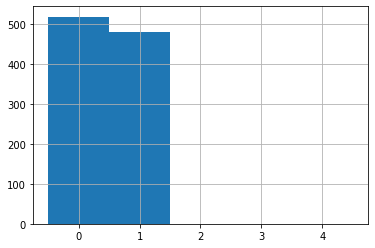

In [8]:
ax = S.hist(bins=np.arange(-0.5,5))
ax.set_xticks(range(0,5))
info

## 5. Descritor e Modelagem

In [9]:
from sklearn.preprocessing import StandardScaler
from rdkit import Chem
from mordred import Calculator, descriptors

# create descriptor calculator with all descriptors
calc = Calculator(descriptors, ignore_3D=True)
df = calc.pandas(moldf['Mol'])

 28%|██▊       | 283/999 [00:16<01:36,  7.45it/s]RDKit WARNING: [13:01:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:01:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:01:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:01:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:01:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:01:02] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 999/999 [00:40<00:00, 24.76it/s]


In [10]:
from fancyimpute import KNN
df_numeric = df.select_dtypes(include=[np.float])

# I now run fancyimpute KNN, 
# it returns a np.array which I store as a pandas dataframe
df_filled = pd.DataFrame(KNN(3).fit_transform(df_numeric))

Imputing row 1/999 with 0 missing, elapsed time: 2.383
Imputing row 101/999 with 0 missing, elapsed time: 2.386
Imputing row 201/999 with 0 missing, elapsed time: 2.386
Imputing row 301/999 with 0 missing, elapsed time: 2.387
Imputing row 401/999 with 0 missing, elapsed time: 2.388
Imputing row 501/999 with 0 missing, elapsed time: 2.388
Imputing row 601/999 with 0 missing, elapsed time: 2.389
Imputing row 701/999 with 0 missing, elapsed time: 2.389
Imputing row 801/999 with 0 missing, elapsed time: 2.390
Imputing row 901/999 with 0 missing, elapsed time: 2.390


,Compound name,SMILES,CASRN,Outcome,LLNA class,LLNA reference,ID,Mol,logP,RowID,Descriptors
999,?-Terpinene,C=C1CC=C(C(C)C)CC1,99-84-3,0,Non-sensitizer,ICCVAM (2013),,,3.30890,999,"[-0.5856917993177108, -0.6185148731001747, -0.8801595634801951, -0.7448330111381471, -0.7462461073700328, -0.6863035480400408, -0.6764810862459343, -0.6301971608195421, -0.5760916210372201, -0.5088953039187323, -0.44537128805802395, -0.5077498259770876, -0.4980370331745935, -0.39209507519815573, -0.3720954437025075, -0.38012894391779384, -0.4086101157050451, -0.45860075110844223, -0.5355233269091939, -0.4474245093640166, -0.741490334615036, -0.6729941660156136, -0.6436298992648304, -0.5977758135650679, -0.6014503956348509, -0.6282651782456964, -0.5937202051111242, -0.5589938546933063, -0.5042849225586404, -0.6806535738366117, -0.7022597294513567, -0.6646417995807721, -0.6250786585475129, -0.6256298652458081, -0.6585809391051076, -0.5858905401056143, -0.5582934163434741, -0.49314160982500616, -0.504148414217236, -0.44679871933232, -0.4002541689594716, -0.35919121676763205, -0.3929485121504964, -0.47551431610497275, -0.5397029734581288, -0.5357887087408212, -0.49476452545547367, -0.47495666036944273, -0.43781091674270456, -0.37283929557051737, -0.33997754809614283, -0.26212248067700405, -0.2636703336733569, -0.4231689576732159, -0.5583968368888156, -0.462926983720355, -0.5111809061760237, -0.4539017970731715, -0.39660298239670067, -0.35671219989629904, -0.28707455176462204, -0.2944850698974168, -0.44228500757464156, -0.556302037664274, -0.46922252549921634, -0.5169255422717769, -0.45846630264524163, -0.4011081233611647, -0.3612907550326734, -0.2897658087165254, -0.2939302936480833, -0.44107392714056787, -0.5566511293925129, -0.4683713749816047, -0.46181023661443477, -0.37876741171645717, -0.3271183054588324, -0.2772814633345604, -0.28660817604291233, -0.3788882437828801, -0.4975513608630422, -0.5304163904977472, -0.4864144219922084, -0.37460893319443855, -0.3942674123977506, -0.30678064233477464, -0.29583946634152997, -0.19551786525771914, -0.17508725697770686, -0.3620591271687238, -0.5533694913858298, -0.43695561530160937, -1.0953741537658215, -0.9983596340024403, -0.8916676090700809, -0.6715606675615831, -0.6406546464956171, -0.45275958329142674, -0.573019383630287, -0.8803795568459558, ...]"
680,2-(4-methyl-2-nitrophenyl)diazenyl-3-oxo-N-phenylbutanamide,CC(=O)C(=NNc1ccc(C)cc1[N+](=O)[O-])C(=O)Nc1ccccc1,2512-29-0,0,,REACH (2008-2014),,,2.89882,680,"[0.6554077556898651, 0.7809822998829643, 1.0548712326204028, 1.0392920970925374, 0.8586914291712895, 0.9083044657996769, 1.0057507873434388, 0.8555203025758217, 0.8187515932170576, 0.9920512892495692, 1.0385511961256713, 0.5068411253726439, 0.4377795832628359, 0.30973689324642223, 0.25000154648356093, 0.22022458855843519, 0.21706426861621392, 0.252720257527472, 0.28679412402285565, 0.2755551762702624, 0.1830651256678447, 0.4336980433965199, 0.38380620897643164, 0.36011765693348047, 0.3934754278152064, 0.38206433083448305, 0.38880515521807296, 0.5039593512079105, 0.49335815819423834, 0.10609174303614227, 0.4538819762665403, 0.41307367735991585, 0.3816834303996402, 0.41874535922375145, 0.4141895216951027, 0.4178752596235446, 0.5429178520979688, 0.5102179840628257, 0.48302740051541565, 0.4134218682654089, 0.34968251890563995, 0.2674425279137191, 0.21533889437837078, 0.24987180204355025, 0.31759728516426156, 0.3961682867558823, 0.3781772894174522, 0.33472709706569165, 0.31894428079477366, 0.13906531917942205, 0.08392730909077226, 0.08631878555799315, 0.10074612789884474, 0.07546651636811044, 0.18197448228333, 0.29604402037181593, 0.38234195723207887, 0.3486471304610971, 0.17017402102103113, 0.12329225642796349, 0.12429919519960922, 0.13455414224387233, 0.10804234277748574, 0.21790204390582157, 0.32110183118189894, 0.39099720827540996, 0.3576535226490848, 0.17067822624679851, 0.12767895433816415, 0.13185252531288055, 0.1421386394659378, 0.10992632251110836, 0.2203741217362209, 0.32696364283427415, 0.311844352
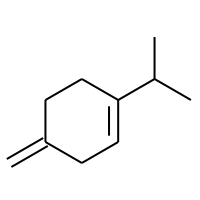
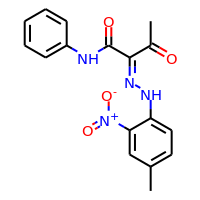
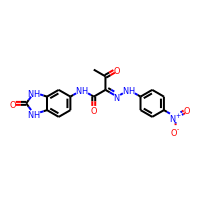
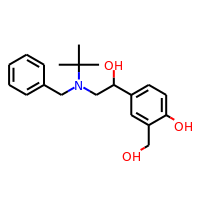
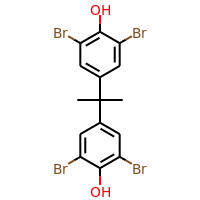

In [11]:
y= np.int32((S))
X = np.array(df_filled)
scaler = StandardScaler()
x=  scaler.fit_transform(X)
moldf['Descriptors'] = x.tolist()
moldf.head()

In [13]:
%%time
############################################## Random Forest ##################################################
paramgrid = {"max_features": [x.shape[1] , x.shape[1] // 2,  x.shape[1] // 4,  x.shape[1] // 12,  x.shape[1] // 10, x.shape[1] // 7, x.shape[1] // 5, x.shape[1] // 3 ],
             "n_estimators": [ 10, 100, 300, 500], }


from sklearn.model_selection import RepeatedKFold
from evolutionary_search import EvolutionaryAlgorithmSearchCV


ncores=48
verbose=1
seed = 24

np.random.seed(seed)

# Kappa Scorer 
kappa_scorer = metrics.make_scorer(quadratic_weighted_kappa, greater_is_better = True)



model = EvolutionaryAlgorithmSearchCV(estimator=RF(class_weight=None),
                                   params=paramgrid,
                                   scoring=kappa_scorer,
                                   cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=seed),
                                   verbose=1,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   iid=True,
                                   refit=True,
                                   n_jobs=ncores)

model.fit(x, y)

# Get best model
best_model = model.best_estimator_

# Fit model with best parameters optimized for quadratic_weighted_kappa
best_model.fit(x,y)


Types [1, 1] and maxint [7, 3] detected
--- Evolve in 32 possible combinations ---
gen	nevals	avg   	min     	max     	std      
0  	50    	0.4031	0.313631	0.433293	0.0354653
1  	23    	0.422479	0.393036	0.437119	0.0100721
2  	28    	0.423147	0.393036	0.437119	0.00939865
3  	22    	0.423344	0.341745	0.437119	0.0142744 
4  	32    	0.423832	0.328385	0.447228	0.0171384 
5  	32    	0.425717	0.409167	0.44686 	0.00827463
Best individual is: {'max_features': 547, 'n_estimators': 300}
with fitness: 0.44685986419003365
CPU times: user 2min 7s, sys: 3.69 s, total: 2min 11s
Wall time: 36min 18s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=547, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## 6. Avaliação Externa e Parametros Estatísticos

### 6.1 5-Fold Externo com todos os dados

k-nearest neighbour distance defined to the AD      :  20
AD Similarity limit      :  0.955667911422706


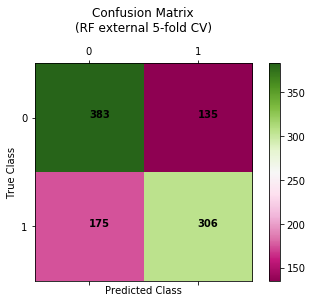

########################################
#   Unbalanced Statistical Parameters  #
########################################
Accuracy: 0.69
Area under the Curve (AUC): 0.69
########################################
#   Balanced Statistical Parameters    #
########################################
Correct Classification Rate (CCR): 0.69
Weighted Kappa:  0.38
########################################
#            Positive Class            #
########################################
Sensitivity (Se): 0.64
Positive Predictive Value (PPV): 0.69
########################################
#            Negative Class            #
########################################
Specificity (Sp): 0.74
Negative Predictive Value (NPV): 0.69
########################################
#     Other Statistical Parameters     #
########################################
Precision:  0.69
Recall:  0.64
F1:  0.66
########################################
#        Applicability Domain          #
##############################

In [14]:
ypreds_folds_total_final,index_test_folds_final, training_labels_AD_final_conc,training_labels_pred_AD_final_conc, y_obs_folds, test_index_ad_final_conc, Dc,index_train_folds, index_test_folds, ypreds_folds, yproba_folds, k  = AD_scikitlearn(x,X,y,20,seed, best_model)
run_statistics(y_obs_folds, ypreds_folds_total_final, label="RF external 5-fold CV", coverage=100)

### 6.2 5-Fold Externo somente com os dados no AD

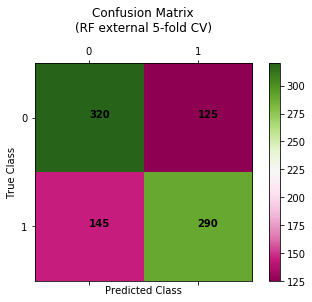

########################################
#   Unbalanced Statistical Parameters  #
########################################
Accuracy: 0.69
Area under the Curve (AUC): 0.69
########################################
#   Balanced Statistical Parameters    #
########################################
Correct Classification Rate (CCR): 0.7
Weighted Kappa:  0.39
########################################
#            Positive Class            #
########################################
Sensitivity (Se): 0.67
Positive Predictive Value (PPV): 0.7
########################################
#            Negative Class            #
########################################
Specificity (Sp): 0.72
Negative Predictive Value (NPV): 0.69
########################################
#     Other Statistical Parameters     #
########################################
Precision:  0.7
Recall:  0.67
F1:  0.68
########################################
#        Applicability Domain          #
#################################

In [15]:
coverage=(((len(training_labels_AD_final_conc))*100)/(float(len(index_test_folds_final)*100))*100)
run_statistics(training_labels_AD_final_conc, training_labels_pred_AD_final_conc, label="RF external 5-fold CV", coverage=coverage)

# 7. Preparar os dados para salvar

### Atributos:

* molecules:
     `pandas.DataFrame()` com os descritores moleculares para o dataset* (usado na `similarity_table()`)
* descriptor:
    *`dict()` com informações do descritor utilizado (usado na `similarity_table()`)
        * function: função de calcular o descritor
        * info: `dict()` com os argumentos de entrada da função
        * name: nome do descritor
* models:
    * `list()` de `dict()` com os dados dos modelos:
        * model: modelo de predição do `scikit-learn`
        * name: nome do modelo
        * longname: descrição curta do modelo
        * descriptor: `dict()` com informações do descritor utilizado
            * function: função de calcular o descritor
            * info: `dict()` com os argumentos de entrada da função
            * name: nome do descritor
         fpDF: `pandas.DataFrame()` com os descritores moleculares para o dataset*
        * dataset: `pandas.DataFrame()` com as informações moleculares de validação do modelo
         applM: distribuição de similaridade do k*-vizinho mais próximo calculada para toda dataset
        * k: ordinal do vizinho mais próximo calculado para o dataset
        * dda: limite estabelecido para que a molécula esteja no domínio de aplicabilidade do modelo

### Métodos:

* `model_table()`:
    * Gera a tabela (`pandas.DataFrame()`) de resultados dos modelos
* `AD_table()`:
    * Gera a tabela (`pandas.DataFrame()`) de domínio de aplicabilidade dos modelos
* `similarity_table`:
    * Gera a tabela (`pandas.DataFrame()`) dos mapas de similaridade das `n` moléculas mais próximas.
    * Gera dados de similaridade que serão usados pela função `similarity_statistics()`
    
##  7.1 Gerando a tabela de dados com todas predições para cada fold

In [16]:
#Get all external Folds and save in Excel format

all_ext_Folds = pd.DataFrame()
for foldnum in range(1,5+1):
    for rep in range(1,5+1):
        final_frame = (len(moldf)-1) 
        fold_N= index_test_folds[foldnum-1]
        pred_N= ypreds_folds[foldnum-1]
        proba_N = yproba_folds[foldnum-1]
        
        tab = moldf.iloc[fold_N,:]
        tab['Prediction'] = pred_N
        tab['Confiability'] = proba_N
        tab['Fold'] = 'Fold {:d} extenal Repetition {:d}'.format(foldnum,rep)

        all_ext_Folds = all_ext_Folds.append(tab).reset_index(drop=True)


cols = ['ROMol','SMILES','Outcome','Prediction','Fold']

### melhorar ##
dX = dict()
[dX.update({i:[val]}) for i,val in enumerate(X)]
dfX = pd.DataFrame.from_dict(dX).T
dfX.columns=['FingerPrint']
dfX['SMILES'] = moldf['SMILES']

#########################

Dict_AD = {}
Dict_AD["FingerPrint"] = dfX
Dict_AD["Folds"] = all_ext_Folds
Dict_AD["k"] = k
Dict_AD["AD.distance.limit"] = Dc.mean()
Dict_AD["distance_AD"] = np.asarray(getNeighborsDitance(X, X, k))
Folds_true= Dict_AD["Folds"]
Folds_true = Folds_true.drop('Descriptors', 1)



###  7.1.1 Mostrando a tabela de dados com todas predições para cada fold (last one)

,Compound name,SMILES,CASRN,Outcome,LLNA class,LLNA reference,ID,Mol,logP,RowID,Prediction,Confiability,Fold
0,?-Terpinene,C=C1CC=C(C(C)C)CC1,99-84-3,0,Non-sensitizer,ICCVAM (2013),,,3.30890,999,1,88.333333,Fold 1 extenal Repetition 1
1,"2-(benzyl)tert-butyl)amino)-1-(?,4-dihydroxy-m-tolyl)ethane",CC(C)(C)N(Cc1ccccc1)CC(O)c1ccc(O)c(CO)c1,24085-03-8,0,Non-sensitizer,ICCVAM (2013),,,3.21860,682,0,66.333333,Fold 1 extenal Repetition 1
2,2-(phenoxy)ethoxybenzene,c1ccc(OCCOc2ccccc2)cc1,104-66-5,0,,REACH (2008-2014),,,3.14440,684,1,60.000000,Fold 1 extenal Repetition 1
3,2-(phenoxy)ethyl 2-methylpropanoate,CC(C)C(=O)OCCOc1ccccc1,103-60-6,0,,REACH (2008-2014),,,2.26460,685,1,61.333333,Fold 1 extenal Repetition 1
4,2-[(E)-2-cyano-3-(4-diethylaminophenyl)prop-2-enoyl]oxyethyl-[3-[(E)-2-cyano-3-(4-diethylaminophenyl)prop-2-enoyl]oxypropyl]-dimethylazanium chloride,CCN(CC)c1ccc(C=C(C#N)C(=O)OCCC[N+](C)(C)CCOC(=O)C(C#N)=Cc2ccc(N(CC)CC)cc2)cc1,78181-99-4,0,,REACH (2008-2014),,,5.44606,702,0,55.333333,Fold 1 extenal Repetition 1

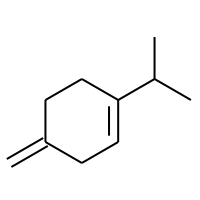
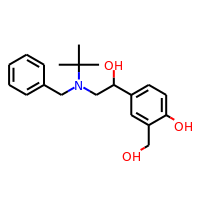
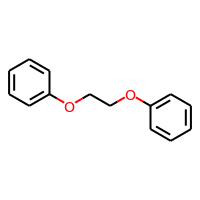
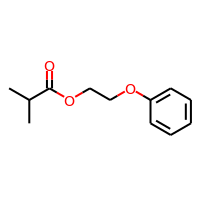
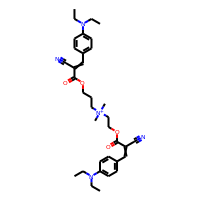

In [17]:
Folds_true.head()

In [18]:

newKeys = {'FingerPrint':'fpDF', 'Folds':'molDF',
        'k':'k', 'AD.distance.limit':'dda',
        'distance_AD':'applM'}

    # Renomeando as chaves
Dict_AD = {newKeys[key]:value for key,value in Dict_AD.items()}
    # Filtrando a tabela
Dict_AD['molDF'] = filter_table(Dict_AD['molDF'])

Dict_AD['molDF']['mol'] = list(map(Chem.MolFromSmiles,Dict_AD['molDF'].index))


RDKit WARNING: [13:41:59] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:41:59] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:41:59] WARNING: not removing hydrogen atom without neighbors


##  7.2 Definir as categorias (resultado médias dos folds por molécula)

,Outcome,Prediction,Confiability,mol
SMILES,,,,
BrC1CC(Br)CC(Br)CC(Br)CC(Br)CC(Br)C1,0,Sensitizer,52.666667,
BrCCBr,0,Non-Sensitizer,71.000000,
BrCCc1ccccc1,1,Sensitizer,84.333333,
BrCc1ccccc1,1,Sensitizer,72.333333,
C#CC(O)CCCCC,1,Sensitizer,59.666667,

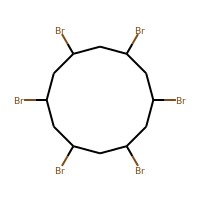
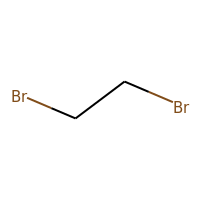
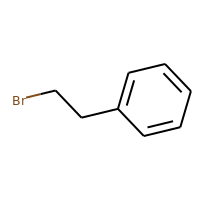
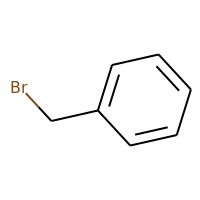
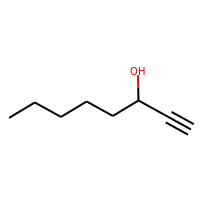

In [19]:
Dict_AD['molDF']['Prediction']=np.where(Dict_AD['molDF']['Prediction']>=0.6, 'Sensitizer', 'Non-Sensitizer')
Dict_AD['molDF'].head()

##  7.3 Mostras a distribuição da similaridade dos dados  AD

(array([  2.,   0.,   1.,   2.,   8.,  21.,  48., 130., 353., 434.]),
 array([0.85811966, 0.87150952, 0.88489938, 0.89828923, 0.91167909,
        0.92506895, 0.93845881, 0.95184867, 0.96523853, 0.97862839,
        0.99201824]),
 <a list of 10 Patch objects>)

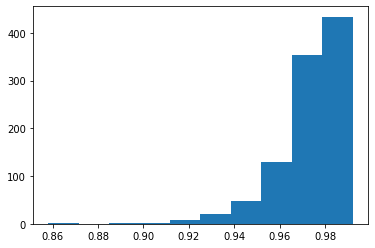

In [20]:
import matplotlib.pyplot as plt
plt.hist(Dict_AD['applM'])

#  8. Salvando modelo e os dados adicionais

In [21]:
from sklearn.externals import joblib
joblib.dump(best_model, 'model/Modelo_Skin_Sens_mordred.pkl',compress=9)

['model/Modelo_Skin_Sens_mordred.pkl']

In [22]:
import bz2
import pickle
import _pickle as cPickle
with bz2.BZ2File('model/Dados_adicionais_Skin_Sens_mordred.pbz2', 'w') as f:
    pickle.dump(Dict_AD, f)
    